<h1>House Price Prediction</h1>

<h4>Import Required Libraries</h4>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pickle

sns.set(style="whitegrid", palette="muted")

In [105]:
df = pd.read_csv("D:/House Price Prediction/house-prices-advanced-regression-techniques/train.csv")
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<h4>Basic Info and missing values</h4>

In [107]:
print(df.shape)
print(df.info())
print(df.isnull().sum().sort_values(ascending=False).head(10))

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

<h4>Target Variable Distribution</h4>

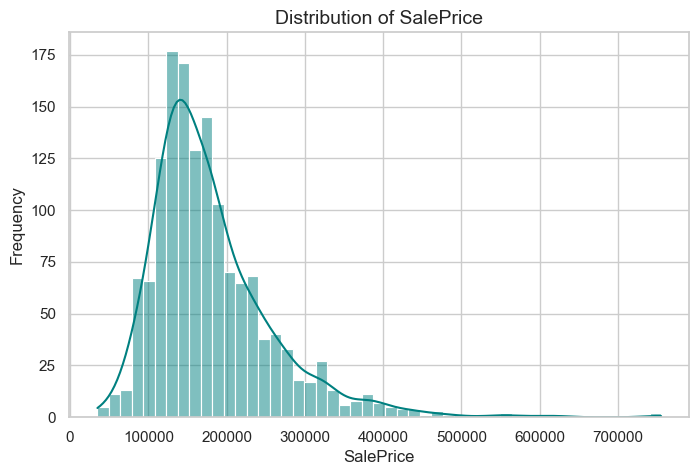

In [111]:
plt.figure(figsize=(8,5))
sns.histplot(df['SalePrice'], kde=True, color='teal')
plt.title('Distribution of SalePrice', fontsize=14)
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

<h4>Correlation heatmap (top features)</h4>

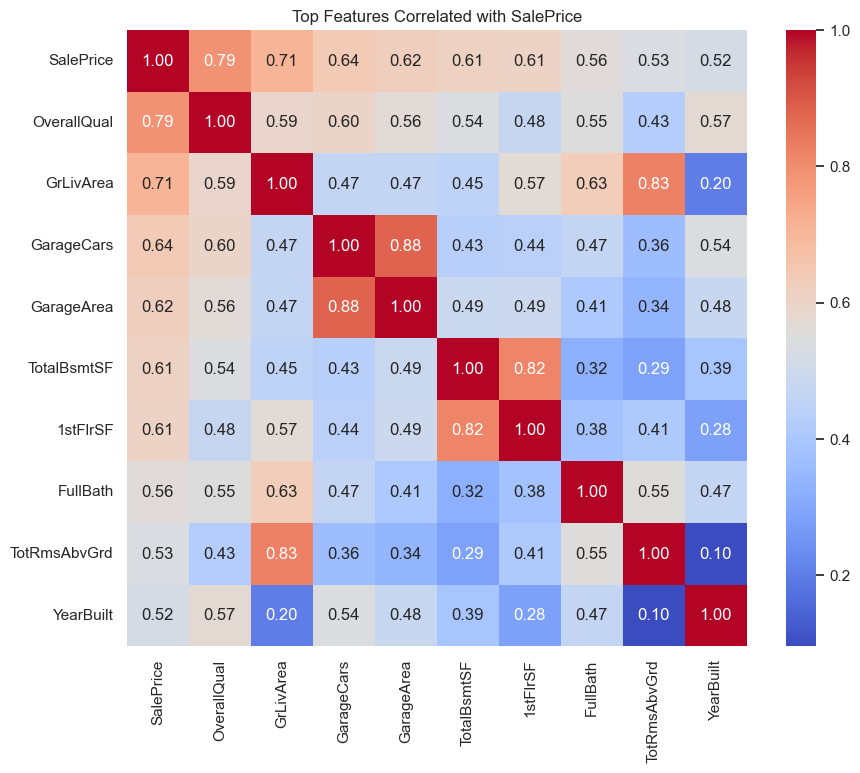

In [114]:
corr = df.corr(numeric_only=True)
top_corr = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index
plt.figure(figsize=(10,8))
sns.heatmap(df[top_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Top Features Correlated with SalePrice')
plt.show()


<h4>SalePrice vs OverallQual</h4>

C:\Users\Admin\AppData\Local\Temp\ipykernel_18744\3305983535.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')


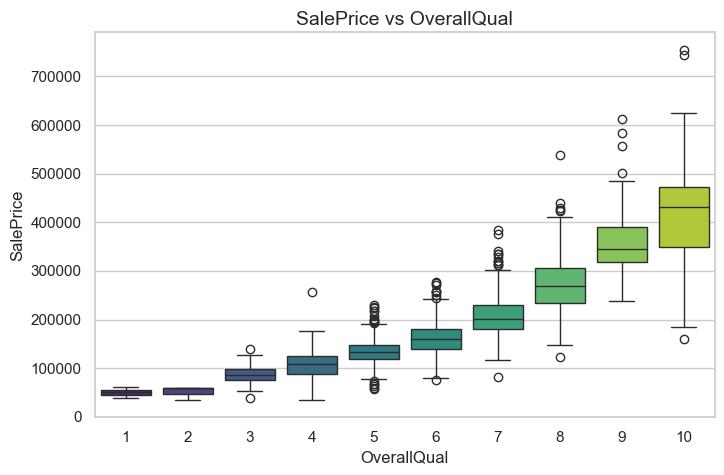

In [117]:
plt.figure(figsize=(8,5))
sns.boxplot(x='OverallQual', y='SalePrice', data=df, palette='viridis')
plt.title('SalePrice vs OverallQual', fontsize=14)
plt.show()


<h4>SalePrice vs GrLivArea</h4>

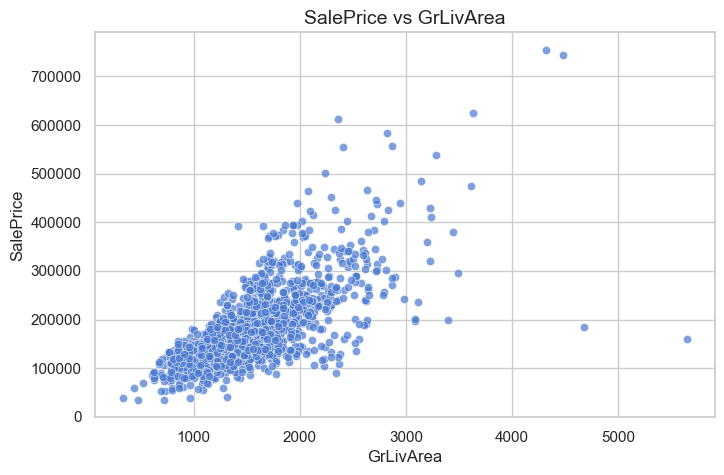

In [120]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df, alpha=0.7)
plt.title('SalePrice vs GrLivArea', fontsize=14)
plt.show()


<h4>Prepare data for pipeline</h4>

In [123]:
y = df['SalePrice']
X = df.drop(columns=['SalePrice', 'Id'], errors='ignore')

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()


<h4>Pipeline</h4>

In [126]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])


<h4>Train/Test Split</h4>

In [129]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


<h4>Train and Evaluate</h4>

In [132]:
model_pipeline.fit(X_train, y_train)

y_train_pred = model_pipeline.predict(X_train)
y_test_pred  = model_pipeline.predict(X_test)

def rmse(a, b): 
    return np.sqrt(mean_squared_error(a, b))

print("Training:")
print(f"  R2   : {r2_score(y_train, y_train_pred):.4f}")
print(f"  MAE  : {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"  RMSE : {rmse(y_train, y_train_pred):.2f}")

print("\nTesting:")
print(f"  R2   : {r2_score(y_test, y_test_pred):.4f}")
print(f"  MAE  : {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"  RMSE : {rmse(y_test, y_test_pred):.2f}")


Training:
  R2   : 0.9023
  MAE  : 15537.09
  RMSE : 24142.96

Testing:
  R2   : 0.8723
  MAE  : 20466.13
  RMSE : 31294.99


<h4>Save Model</h4>

In [135]:
with open('house_model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)
